<a href="https://colab.research.google.com/github/catPotat/rn-hg-gpt2-playground/blob/main/Huggingface_GPT_2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Author: *N H Long*

This notebook is all about experimenting GPT-2's ability to generate.

This notebook is dedicated to the SS2 class I'm taking now.

The dateline for a published research is in May (more info later).

<br>

---

<br>
<img src="https://i.redd.it/j586af7nxvu41.jpg" alt="Watching a train model" height=300>

# 🏁 Initialize

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sat Apr 10 18:02:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
!pip install transformers==4.4.2
!pip install datasets
!pip install python-dotenv
try:
    from google.colab import output
    output.clear()
    from google.colab import drive
    drive.mount('/content/drive')
except: pass

Mounted at /content/drive


In [ ]:
%load_ext dotenv
%dotenv drive/MyDrive/.env.gdrive
import os
from tqdm.notebook import tqdm
import torch

# 🔧 Tuning

## 🍃 Data source
After this you will get big text lines `text_entries`

#### b) from my mongodb

it has english pokedex and people's tweets

In [ ]:
MONG_USER = os.getenv('MONG_ROUSER')
MONG_PWD  = os.getenv('MONG_ROPWD')
MONG_HOST = os.getenv('MONG_HOST')
MONG_PORT = os.getenv('MONG_PORT')

from pymongo import MongoClient
from bson.objectid import ObjectId

uri = f"mongodb://{MONG_USER}:{MONG_PWD}@{MONG_HOST}:{MONG_PORT}/dataDumpingGround"
client = MongoClient(uri)
client

MongoClient(host=['171.244.50.232:27017'], document_class=dict, tz_aware=False, connect=True)

In [ ]:
db = client['dataSoup']
dataSoup_col = db["pot1"]
pokedex_text_entries_plain = dataSoup_col.find_one({'name': 'pokedex text_entries_plain'})
text_entries = pokedex_text_entries_plain['content']
# text_entries

In [ ]:
db = client['dataDumpingGround']
tw_profile_col = db["twitterProfiles"]
tw_profile = tw_profile_col.find_one({'screen_name': 'billwurtz'})
tw_profile

{'Absent keys': ['withheld_in_countries', 'withheld_scope'],
 'Last updated': datetime.datetime(2021, 3, 21, 10, 42, 40, 980000),
 '_id': ObjectId('6004a17d0b73eae2a9b6c5b5'),
 'created_at': 'Fri Apr 29 09:57:13 +0000 2011',
 'default_profile': 'False',
 'default_profile_image': 'False',
 'description': 'is self',
 'favourites_count': 22713,
 'followers_count': 350279,
 'friends_count': 78,
 'id': 289853473,
 'listed_count': 368,
 'location': '',
 'name': 'bill wurtz',
 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/289853473/1435339266',
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1016862391823360000/BeQ1lMU7_normal.jpg',
 'protected': 'False',
 'screen_name': 'billwurtz',
 'statuses_count': 3100,
 'url': 'https://t.co/WGqYlp4ab6',
 'verified': 'True'}

Cleanse

In [ ]:
from pprint import pprint
import re
from sys import maxsize as inf
text_entries = []
LIMIT = inf

tweet_col = db["twitterTweets"]
tweet_cursor = tweet_col.find({'Author_id': 289853473})
for tweet in tweet_cursor.limit(LIMIT):
    # pprint(tweet)
    text = tweet.get('full_text')
    if text.startswith('RT @'):
        continue
    text = re.sub(r'\@(.*?)\ ', '', text)
    text = re.sub(r'\#(.*?)\ ', '', text)
    text = re.sub(r'(https?:\/\/t.co\/)(.*)', '', text)
    text = re.sub(r'\n\nbill wurtz', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\'', '', text)
    text_entries.append(text)
 
# text_entries

Visualize insight

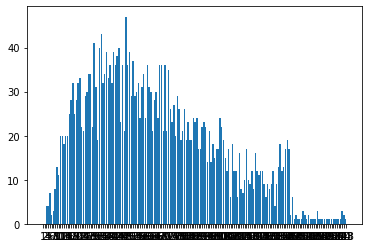

In [ ]:
entry_len = {x: 0 for x in range(255)}
 
for entry in text_entries:
    # if text_len := len(entry) in entry_len:
    text_len = len(entry)
    entry_len[text_len] += 1
entry_len

import matplotlib.pyplot as plt
plt.bar(range(len(entry_len)), list(entry_len.values()))
plt.show()

#### c) pictures as text

[pkm refs](https://colab.research.google.com/drive/1SdgyibJJKpPmMFX9UD1r7ZOZJHJfbm1z?authuser=2#scrollTo=oLfKBltYZVeq)

In [ ]:
!mkdir -p datasets/{fragments,all-pics}/
# !unzip "drive/My Drive/datasets/Eeveelutions/sap1231-251020.zip" -d datasets/fragments/
# !unzip "drive/My Drive/datasets/Eeveelutions/evhub#evlution-pics.zip" -d datasets/fragments/
!unzip "/content/drive/MyDrive/datasets/gpt2-experiments/synthed-pics.zip" -d datasets/
output.clear()
'OK'

'OK'

In [ ]:
import shutil
from PIL import Image
import math

IMG_WIDTH = 64
IMG_HEIGHT = 64
LINE_SPLIT_CHAR = '.'
PIXEL_SPLIT_CHAR = ' '
IMAGE_SPLIT_CHAR = '\n'
CHAR_CODE_SHIFT = 48 # starts from "0"
IMAGES_PATH = 'datasets/synthed-pics/'
IMG_TXT_PATH = f'drive/MyDrive/datasets/Eeveelutions/all-images-{IMG_WIDTH}.txt'
IMG_TXT_PATH = f'drive/MyDrive/datasets/gpt2-experiments/synthed-poster-64-space.txt'

In [ ]:
for root, dirs, files in tqdm( os.walk('./datasets/', topdown=False) ):
    for name in files:
        if 'SoloEevee/Umbr' not in root: continue
        if 'NotEevee' in root: continue
        if 'Grouped' in root: continue
        file_path = os.path.join(root, name)
        # print(file_path)
        shutil.copyfile(file_path, os.path.join(IMAGES_PATH, name))

108it [00:00, 269.37it/s]


In [ ]:
text_entries = []
for f in tqdm( os.listdir(IMAGES_PATH) ):
    if f.split('.')[-1] not in ['png', 'gif', 'jpg', 'jpeg']:
      continue
    image = Image.open(os.path.join(IMAGES_PATH, f)).convert('RGBA')
    # ratio check
    rtio = image.size[0] / image.size[1] # width/height
    gndRtio = IMG_WIDTH / IMG_HEIGHT
    if rtio > gndRtio*1.6 or rtio < 1/gndRtio*0.7:
        continue
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    pixels = image.load()
    lines = []
    for y in range(IMG_HEIGHT):
        split = []
        for x in range(IMG_WIDTH):
            s = '~'
            color = pixels[x, y]
            if len(color) < 4 or color[3] > 128:
                r, g, b = color[0:3]
                mR = math.floor(r/64) # 6-bit color
                mG = math.floor(g/64)
                mB = math.floor(b/64)
                c = 0;
                c += mR
                c = c << 2
                c += mG
                c = c << 2
                c += mB
                s = chr(c+CHAR_CODE_SHIFT)
            split.append(s)
        lines.append(PIXEL_SPLIT_CHAR.join(split))
    out_ = LINE_SPLIT_CHAR.join(lines)
    text_entries.append(out_)
    mirrored = LINE_SPLIT_CHAR.join(
        [l[::-1] for l in lines]
    )
    text_entries.append(mirrored)
    
with open(IMG_TXT_PATH, 'w+') as f:
    f.write(IMAGE_SPLIT_CHAR.join(text_entries))

100%|██████████| 8000/8000 [00:48<00:00, 164.24it/s]


In [ ]:
output = ''
for f in tqdm( os.listdir(IMAGES_PATH) ):
    ext = f.split('.')[-1]
    if ext not in ['png', 'gif', 'jpg', 'jpeg']:
      continue
    image = Image.open(os.path.join(IMAGES_PATH, f)).convert('RGBA')
    pixels = image.load()
    width = image.size[0]
    height = image.size[1]
    lines = []
    for y in range(height):
        padLength = len(str(width))
        padded = str(y).zfill(padLength)
        split = [padded + 'd']
        for x in range(width):
            color = pixels[x, y]
            s = '~'
            if len(color) < 4 or color[3] > 128:
                r, g, b = color[0], color[1], color[2]
                if r == 85 and g == 85 and b == 85:
                    s = 'a' # use grayscale character 1
                elif r == 170 and g == 170 and b == 170:
                    s = 'b' # use grayscale character 2
                else: # use one of 64 color characters
                    mR = math.floor(r/64)
                    mG = math.floor(g/64)
                    mB = math.floor(b/64)
                    c = 0;
                    c += mR
                    c = c << 2
                    c += mG
                    c = c << 2
                    c += mB
                    s = chr(c+33)
            split.append(s)
        lines.append(' '.join(split))
    reversed = []
    for line in lines:
        reversed.insert(0, (line.replace('d ', 'u ', 1)))
    output += '\n'.join(lines)
    # output += '\n'.join(reversed)
print('saving output')
with open('all-images.txt', 'w') as output_file:
    output_file.write(output)
print('done !')

100%|██████████| 8000/8000 [00:41<00:00, 193.15it/s]


saving output
done !


In [ ]:
with open(IMG_TXT_PATH, 'r') as f:
    content = f.read()
    text_entries = content.split(IMAGE_SPLIT_CHAR)

text_entries

#### d) wattpad stories

In [ ]:
TEXT_PATH = '/content/drive/MyDrive/datasets/kaggle-fork/2'

In [ ]:
text_entries = []

for root, dirs, files in os.walk(TEXT_PATH, topdown=False):
    for name in files:
        file_path = os.path.join(root, name)
        print(file_path)
        with open(file_path) as fp: 
            # text_entries += fp.read() +'\n'
            for line in fp:
                text_entries.append(line.strip())

/content/drive/MyDrive/datasets/kaggle-fork/2/internet_archive_scifi_v3-SPLITTED-1024.txt


#### e) vietnamese 20GB corpus

https://github.com/binhvq/news-corpus

format it using this: https://github.com/vncorenlp/VnCoreNLP

<br>Number of words per line distrbution:<br>
<img src="https://drive.google.com/uc?id=1LECbZlwbRX2_YTt_MLRBWPdWxRwtJkre" alt="h" height>

In [ ]:
!git clone https://github.com/vncorenlp/VnCoreNLP.git
!pip install vncorenlp
from vncorenlp import VnCoreNLP
annotator = VnCoreNLP('/content/VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators='wseg', max_heap_size='-Xmx500m')

def word_segment(text):
    word_segmented_text = annotator.tokenize(text) 
    sentences = []
    for sentence in word_segmented_text:
        sentences.append(' '.join(sentence))
    return ' '.join(sentences)

text_entries = []

fatal: destination path 'VnCoreNLP' already exists and is not an empty directory.


In [ ]:
CORPUS_PATH = '/content/drive/MyDrive/datasets/vietnamese-corpus/'
TREATED_CORPUS_PATH = f'{CORPUS_PATH}VnCoreNLP-segmented/'
root, dirs, files = next(os.walk(TREATED_CORPUS_PATH, topdown=False))
files = list( map(lambda x: os.path.join(root, x), files) )

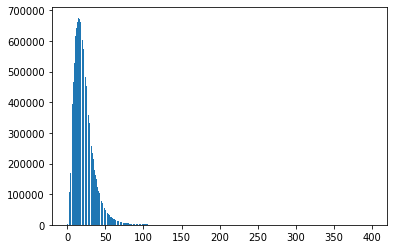

In [ ]:
dump = ""
i = 0
root, dirs, files = next(os.walk(TREATED_CORPUS_PATH, topdown=False))
for j, name in tqdm( enumerate(files), total=len(files) ):
    if j > 20:
        continue
    if not name.split('.')[0].isnumeric():
        continue
    with open(os.path.join(root, name), 'r', encoding="utf8") as f:
        for line in f:
            l = len( line.split() )
            if l < 40:
                continue
            dump += line
            i += 1
with open('temp.txt', 'w+', encoding="utf8") as f:
    f.write(dump)

In [ ]:
!stat /content/temp.txt
!cp /content/temp.txt /content/drive/MyDrive/datasets/vietnamese-corpus/temp.txt

  File: /content/temp.txt
  Size: 578796268 	Blocks: 1130472    IO Block: 4096   regular file
Device: 32h/50d	Inode: 2243365     Links: 1
Access: (0644/-rw-r--r--)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2021-04-10 07:20:09.400472716 +0000
Modify: 2021-04-10 07:20:11.350591736 +0000
Change: 2021-04-10 07:20:11.350591736 +0000
 Birth: -


In [ ]:
dump = ""
i = 0
with open(f'{CORPUS_PATH}corpus-full-0.2.txt', 'r', encoding="utf8") as f:
    # for line in tqdm(f, total=162200680):
    for line in f:
        i += 1
        if i < 3244012:
            continue
        dump += word_segment(line) + '\n'
        if i % 811003 == 0:
            with open(f'{TREATED_CORPUS_PATH}{i}.txt', 'w+', encoding="utf8") as f:
                f.write(dump)
            dump = ""
            print(i)
with open(f'{TREATED_CORPUS_PATH}{i}.txt', 'w+', encoding="utf8") as f:
    f.write(dump)
print(i)

## 🚋 Names and paths

In [ ]:
MODEL_NAME = "gpt2"
MODEL_SAVE_PATH = 'drive/MyDrive/models/VinaPT-0421/vinaPT-attempt-1104/'
TOK_PATH = MODEL_SAVE_PATH + "tokenizer/"
TRAIN_PATH = 'train_dataset.txt'
TEST_PATH = 'test_dataset.txt'
LINE_SPLIT_CHAR = '\n'
MODEL_LENGTH = 1024
!mkdir -p $MODEL_SAVE_PATH

In [ ]:
# ALTERNATIVE
TRAIN_PATH = '/content/drive/MyDrive/datasets/vietnamese-corpus/temp.txt'
TEST_PATH = f'{MODEL_SAVE_PATH}test_dataset.txt'

### 📄 Build txt file

In [ ]:
from sklearn.model_selection import train_test_split

if len(text_entries) == 1:
    text_entries = text_entries[0].split()

train_ds, test_ds = train_test_split(text_entries, test_size=0.1, shuffle=False)
print(f"Train dataset length: {len(train_ds)}")
print(f"Test dataset length: {len(test_ds)}")

Train dataset length: 7365
Test dataset length: 819


In [ ]:
longest_len = 0
def build_text_files(lines, dest_path):
    global longest_len
    dump = ""
    for line in lines:
        if not line.strip():
            continue
        dump += line + LINE_SPLIT_CHAR
        if len(line) > longest_len: # assign max length
            longest_len = len(line)
    with open(dest_path, 'w+') as f:
        f.write(dump)

# build_text_files(text_entries, TRAIN_PATH)
# build_text_files(text_entries, TEST_PATH)
build_text_files(train_ds, TRAIN_PATH)
build_text_files(test_ds, TEST_PATH)

In [ ]:
total_len = 0
max_len = 0
for entry in text_entries:
    l = len(entry)
    if l > max_len:
        max_len = l
    total_len += l
total_len, max_len

(149268147, 7127)

## 🪓 Tokenizer

### a) Train a tokenizer

[how-to](https://huggingface.co/blog/how-to-train)

https://huggingface.co/transformers/main_classes/tokenizer.html

In [ ]:
from tokenizers import ByteLevelBPETokenizer

tok_trainer = ByteLevelBPETokenizer()
tok_trainer.train(
    files=file_ls,
    vocab_size=64000, # same as PhoBERT.vocab_size
    min_frequency=3,
    special_tokens=[
        '<|endoftext|>',
    ]
)
!mkdir -p 'tok/'
tok_trainer.save_model('tok/', "igptkinda")
!mkdir -p $TOK_PATH
!cp 'tok/igptkinda-vocab.json' $TOK_PATH/vocab.json
!cp 'tok/igptkinda-merges.txt' $TOK_PATH/merges.txt

In [ ]:
from transformers import GPT2Tokenizer, AutoTokenizer
tokenizer = GPT2Tokenizer.from_pretrained(TOK_PATH, model_max_length=MODEL_LENGTH)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length

1024

### b) Pretrained

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length = MODEL_LENGTH
# tokenizer.set_truncation_and_padding(max_length=MODEL_LENGTH)
ids = tokenizer.encode(" 9 I J J : : J.J J J J J ")
ids

[860, 314, 449, 449, 1058, 1058, 449, 13, 41, 449, 449, 449, 449, 220]

## 📚 .txt to _dataset

https://huggingface.co/docs/datasets/quicktour.html

In [ ]:
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling

train_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=TRAIN_PATH,
    block_size=512
)
test_dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path=TEST_PATH,
    block_size=tokenizer.model_max_length
)
train_dataset[0]

In [ ]:
from datasets import load_dataset

def encode(examples):
    examples['text'][0] += '\n'
    return tokenizer(examples['text'],
                     truncation=True, padding=False)

dataset = load_dataset('text', data_files=files)
dataset = dataset.map(encode, batched=True)
dataset.set_format(type='torch', columns=['input_ids'])
tokenizer.decode(dataset['train'][0]['input_ids'])

Using custom data configuration default-bc797c37cb4ddd08


KeyboardInterrupt: ignored

## 🧠 The model

https://huggingface.co/transformers/model_doc/gpt2.html

In [ ]:
from transformers import GPT2Config, GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(
    MODEL_NAME,
    # MODEL_SAVE_PATH + 'checkpoint-16000',
    gradient_checkpointing=True,
    use_cache=False
)
# config = GPT2Config(
#     vocab_size=tokenizer.vocab_size,
#     n_positions=MODEL_LENGTH,
#     # n_embd=700,
#     gradient_checkpointing=True,
#     use_cache=False
# )
# model = GPT2LMHeadModel(config)
model

## 🎢 GD!

API docs: [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments) ,
[Torch optim](https://pytorch.org/docs/stable/optim.html)


In [ ]:
from transformers import Trainer, TrainingArguments, get_scheduler, DataCollatorForLanguageModeling
from torch import optim

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH,
    overwrite_output_dir=True,
    num_train_epochs=5,
    # max_steps=40_000,
    # save_strategy="epoch",
    save_steps=40000,
    logging_steps=4000,
    # learning_rate=1e-4,
    # evaluation_strategy="epoch",
    gradient_accumulation_steps=2,

# Turn down on memory usage
    per_device_train_batch_size=4,
    # per_device_eval_batch_size=64,
    # adafactor=True
)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = get_scheduler("polynomial", optimizer, num_warmup_steps=1000,
                          num_training_steps=0) # ?

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                           mlm=False)
trainer = Trainer(model=model,
    args=training_args,
    train_dataset=dataset['train'],
    # eval_dataset=test_dataset,
    # optimizers=(optimizer, scheduler),
    # compute_metrics=[],
    data_collator=collator,
)
trainer.train()

Step,Training Loss
1000,4.223600
2000,4.182300
3000,4.147400
4000,4.118500
5000,4.099400
6000,4.064800
7000,4.057200
8000,4.036000
9000,4.032600
10000,4.023700


KeyboardInterrupt: ignored

# 📈 Evaluation

https://colab.research.google.com/drive/19LWO1LlZIhii6PCw9GJBLKkW0ZfdMLEj